In [95]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# Read data 

In [81]:
df_labels = pd.read_csv("dataset/train.csv")
df_photo_to_biz = pd.read_csv("dataset/train_photo_to_biz_ids.csv")
df = df_photo_to_biz.join(other=df_labels.set_index('business_id'), how='left', on='business_id').drop(columns="business_id")

In [82]:
df

,photo_id,labels
0,204149,3 8
1,52779,1 2 3 5 6 7
2,278973,1 2 3 4 5 6 7
3,195284,1 2 3 4 5 6 7
4,19992,1 2 3 4 5 6 7
...,...,...
234837,325414,1 4 5 6 7
234838,301030,1 2 5 6
234839,355839,1 2 5 6 7 8
234840,20474,0 1 2 3 5 6 7 8


In [83]:
print(df.isnull().sum().sum())

297


In [84]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [85]:
df

,photo_id,labels
0,204149,3 8
1,52779,1 2 3 5 6 7
2,278973,1 2 3 4 5 6 7
3,195284,1 2 3 4 5 6 7
4,19992,1 2 3 4 5 6 7
...,...,...
234540,325414,1 4 5 6 7
234541,301030,1 2 5 6
234542,355839,1 2 5 6 7 8
234543,20474,0 1 2 3 5 6 7 8


Business attributes, that corresponds to labels:

0: good_for_lunch

1: good_for_dinner

2: takes_reservations

3: outdoor_seating

4: restaurant_is_expensive

5: has_alcohol

6: has_table_service

7: ambience_is_classy

8: good_for_kids


In [86]:
labels_str = [
    "good for lunch", "good for dinner", "takes reservations",
    "outdoor seating", "restaurant is expensive", "has alcohol",
    "has table service", "ambience is classy", "good for kids"
]

In [87]:
LABELS_NUM = 9

In [88]:
def encode_label(l):
    res = np.zeros(LABELS_NUM)
    for i in l:
        res[i] = 1
    return res

train_L = np.vstack(df['labels'].apply(lambda x: tuple(sorted(int(t) for t in x.split()))).apply(encode_label))
df = pd.concat([df, pd.DataFrame(train_L)], axis=1).drop(columns=["labels"])
df

,photo_id,0,1,2,3,4,5,6,7,8
0,204149,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,52779,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,278973,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,195284,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,19992,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
234540,325414,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
234541,301030,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
234542,355839,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
234543,20474,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [89]:
def show_image(opencv_image):
    b,g,r = cv2.split(opencv_image)
    rgb_image = cv2.merge([r,g,b])
    plt.imshow(rgb_image)
    plt.show()

In [90]:
def get_img(img_id):
    return cv2.imread("dataset/train_photos/" + str(img_id) + ".jpg")

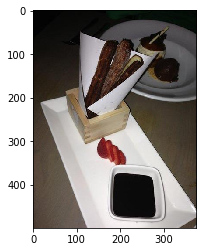

In [91]:
show_image(get_img(int(df.sample(1).photo_id)))

# Data investigating

## Class balance

In [103]:
def show_classes_count(df):
    labels = df.drop(columns=["photo_id"])
    labels_count = []
    for i in range(LABELS_NUM):
        labels_count.append(df[i].sum())
    plt.bar(x=range(LABELS_NUM), height=labels_count, tick_label=labels_str)

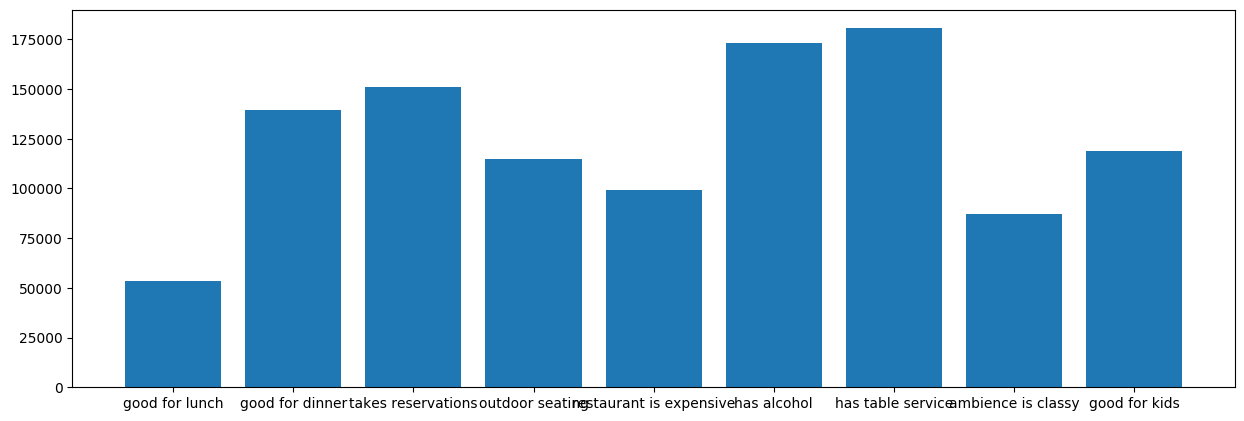

In [153]:
show_classes_count(df)

Generally, it is hard task to balance classes in multi-label classification, but let's try to do it in easy way. First, let's use upsampling for good for lunch, as it has the smallest amount os samples

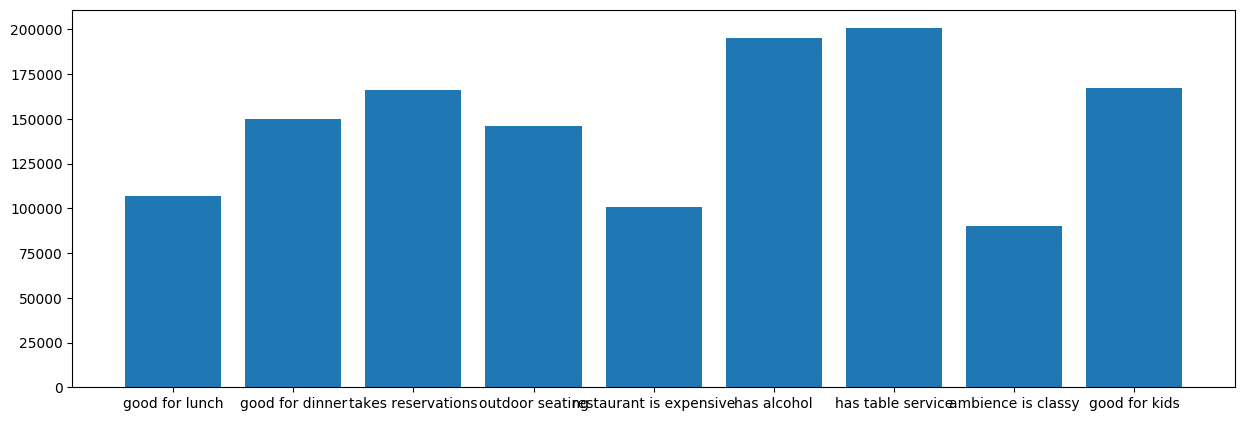

In [154]:
show_classes_count(df.append(df[df[0] == 1]))

We can see, that it improved the situation, but we have much more samples from 5 and 6 labels comparing to 4 and 7. So let's use downsampling for 5 and 6 classes, but while removing samples take into account, that samples, that have 0, 4 and 7 classes don't remove

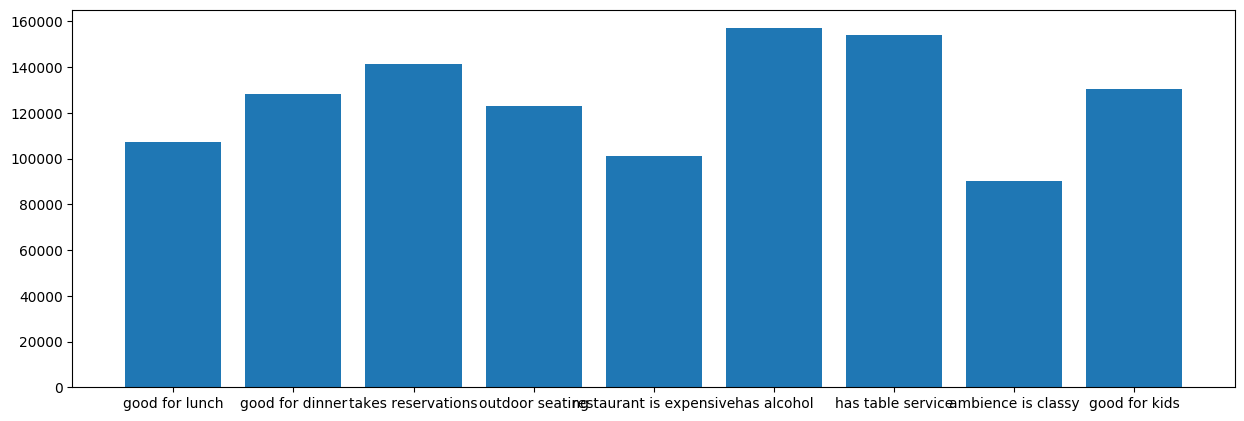

In [157]:
a = df[df[6] == 1]
a = df[df[5] == 1].append(a[a[5] == 0])
a = a[a[7] == 0]
a = a[a[4] == 0]
a = a[a[0] == 0]
a = df.iloc[list(set(df.index) - set(a.index))]
balanced_df = a.append(a[a[0] == 1])
show_classes_count(balanced_df)

For now, 7 classs could have more samples, but generally classes are much more balanced

# Feature extraction

## Inception

In [19]:
from keras.applications import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Dense

In [26]:
def modify_model(original_model):
    bottleneck_input = original_model.get_layer(index=0).input
    bottleneck_output = original_model.get_layer(index=0).output
    bottleneck_model = Model(inputs=bottleneck_input, outputs=bottleneck_output)

    for layer in bottleneck_model.layers:
        layer.trainable = False

    new_model = Sequential()
    new_model.add(bottleneck_model)
    new_model.add(Dense(LABELS_NUM, activation='softmax', input_dim=2048))
    new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return new_model

In [27]:
model = modify_model(InceptionV3())